## Query Redshift Serverless From Notebook

- [serverless cannot query some STV tables](https://docs.aws.amazon.com/redshift/latest/mgmt/serverless-monitoring.html#serverless_views-monitoring)

In [4]:
!pip install redshift-connector --quiet 

In [1]:
import redshift_connector
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
conn = redshift_connector.connect(
     host='hello.392194582387.ap-southeast-1.redshift-serverless.amazonaws.com',
     database='dev',
     port=5439,
     user='admin',
     password='Admin2023'
  )

In [116]:
cursor = conn.cursor()

In [117]:
def run_query(cursor, query):
    """
    """
    # run query 
    cursor.execute(query)
    # return data frame 
    df: pd.DataFrame = cursor.fetch_dataframe()
    # return 
    return df

## Table Information

In [87]:
query = """
select * from SVV_TABLE_INFO
where schema='public'
"""

In [88]:
df = run_query(cursor=cursor,query=query)

In [89]:
df.head(5)

,database,schema,table_id,table,encoded,diststyle,sortkey1,max_varchar,sortkey1_enc,sortkey_num,...,empty,unsorted,stats_off,tbl_rows,skew_sortkey1,skew_rows,estimated_visible_rows,risk_event,vacuum_sort_benefit,create_time
0,dev,public,105969,nation,"Y, AUTO(ENCODE)",AUTO(ALL),AUTO(SORTKEY),152,None,0,...,0,None,0.00,25,None,None,25,None,None,2023-07-31 08:52:21.369290
1,dev,public,105967,region,"Y, AUTO(ENCODE)",AUTO(ALL),AUTO(SORTKEY),152,None,0,...,0,None,0.00,5,None,None,5,None,None,2023-07-31 08:52:20.457945
2,dev,public,105977,supplier,"Y, AUTO(ENCODE)",AUTO(EVEN),AUTO(SORTKEY),101,None,0,...,0,None,0.00,1100000,None,None,1100000,None,None,2023-07-31 08:52:24.740978
3,dev,public,105981,partsupp,"Y, AUTO(ENCODE)",AUTO(EVEN),AUTO(SORTKEY),199,None,0,...,0,None,0.00,80000000,None,None,80000000,None,None,2023-07-31 08:52:26.240393
4,dev,public,105973,orders,"Y, AUTO(ENCODE)",AUTO(EVEN),AUTO(SORTKEY),79,None,0,...,0,None,0.00,76000000,None,None,76000000,None,None,2023-07-31 08:52:23.265122


## User Information 

In [121]:
query="""
select * from pg_tables
where schemaname='public'
"""

In [122]:
df = run_query(cursor=cursor, query=query)

In [124]:
df.head(10)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,public,users,IAM:minh,None,False,False,False
1,public,venue,IAM:minh,None,False,False,False
2,public,category,IAM:minh,None,False,False,False
3,public,dwdate,IAM:minh,None,False,False,False
4,public,event,IAM:minh,None,False,False,False
5,public,listing,IAM:minh,None,False,False,False
6,public,sales,IAM:minh,None,False,False,False
7,public,region,admin,None,False,False,False
8,public,nation,admin,None,False,False,False
9,public,supplier,admin,None,False,False,False


## Check User Permission on Tables 

In [96]:
query="""
SELECT
    schemaname,
    tablename,
    usename,
    HAS_TABLE_PRIVILEGE(users.usename,  schemaname || '.' || tablename, 'select') AS sel
FROM
(SELECT * from pg_tables WHERE schemaname = 'public' and tablename in ('customer', 'orders')) as tables,
(SELECT * FROM pg_user) AS users;
"""

In [97]:
df = run_query(cursor=cursor, query=query)

In [98]:
df.head()

,schemaname,tablename,usename,sel
0,public,customer,rdsdb,True
1,public,customer,IAM:minh,True
2,public,customer,admin,True
3,public,customer,IAMR:RoleForSagemakerNotebookHello,False
4,public,orders,rdsdb,True


In [99]:
query="""
SELECT
    u.usename,
    s.schemaname,
    has_schema_privilege(u.usename,s.schemaname,'create') AS user_has_select_permission,
    has_schema_privilege(u.usename,s.schemaname,'usage') AS user_has_usage_permission
FROM
    pg_user u
CROSS JOIN
    (SELECT DISTINCT schemaname FROM pg_tables) s
WHERE
    u.usename = 'admin'
    AND s.schemaname = 'public'
"""

In [100]:
df = run_query(cursor=cursor, query=query)

In [102]:
df

,usename,schemaname,user_has_select_permission,user_has_usage_permission
0,admin,public,True,True


## Query on TPCH Dataset 

In [148]:
query= """
select c_name, sum(o_totalprice) as total_purchase from (
  select c_name, o_totalprice from {0}.customer, {0}.orders
  where customer.c_custkey = orders.o_custkey
) group by c_name order by total_purchase desc limit 10;
""".format("public")

In [149]:
df = run_query(cursor=cursor, query=query)

In [150]:
df

,c_name,total_purchase
0,Customer#013126828,5284956.8700
1,Customer#009656446,5024357.9500
2,Customer#000903898,4920615.5300
3,Customer#009269644,4882787.0900
4,Customer#004661104,4855364.5900
5,Customer#005020900,4800622.6100
6,Customer#006629596,4790648.7700
7,Customer#011930023,4767005.8000
8,Customer#003224719,4763507.0800
9,Customer#002444146,4735799.3700


In [151]:
print(df.head())

               c_name total_purchase
0  Customer#013126828   5284956.8700
1  Customer#009656446   5024357.9500
2  Customer#000903898   4920615.5300
3  Customer#009269644   4882787.0900
4  Customer#004661104   4855364.5900


In [128]:
names = [x.split('#')[-1][-3:] for x in df.c_name.to_list()]

In [129]:
df = df.astype({"total_purchase": "float"})

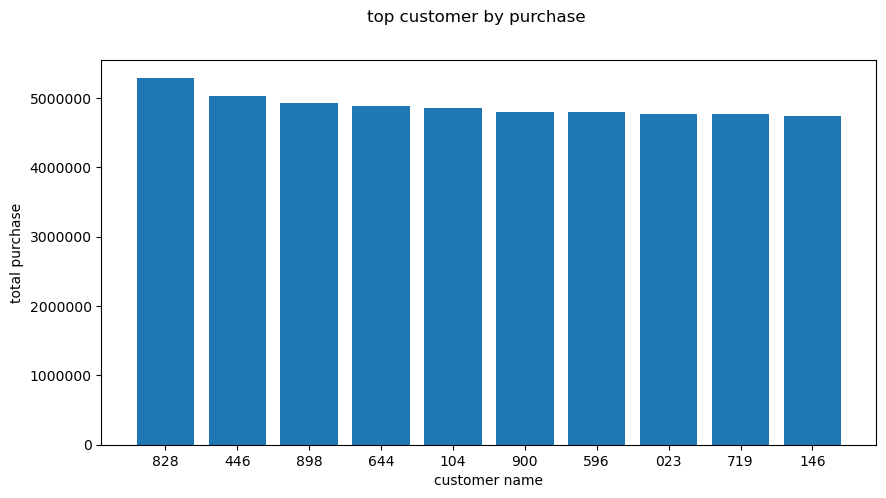

In [132]:
fig,axes = plt.subplots(1,1,figsize=(10,5))
axes.bar(names, df.total_purchase)
axes.set_ylabel('total purchase')
axes.set_xlabel('customer name')
axes.ticklabel_format(useOffset=False, style='plain', axis='y')
fig.suptitle('top customer by purchase')
plt.show()

## Serverless Usage 

In [152]:
query="""
select * from sys_serverless_usage
order by charged_seconds desc;
"""

In [153]:
df = run_query(cursor=cursor,query=query)

In [154]:
df

,start_time,end_time,compute_seconds,compute_capacity,data_storage,cross_region_transferred_data,charged_seconds
0,2023-08-01 08:42:00,2023-08-01 08:43:00,288.0,32.0,34884,0,16416
1,2023-08-01 07:46:00,2023-08-01 07:47:00,1920.0,32.0,34884,0,14144
2,2023-08-01 08:30:00,2023-08-01 08:31:00,1920.0,32.0,34885,0,8544
3,2023-08-01 08:41:00,2023-08-01 08:42:00,1920.0,32.0,34884,0,1920
4,2023-08-01 08:32:00,2023-08-01 08:33:00,1920.0,32.0,34885,0,1920
...,...,...,...,...,...,...,...
121,2023-07-31 11:20:00,2023-07-31 11:21:00,0.0,0.0,34890,0,0
122,2023-07-31 08:48:00,2023-07-31 08:49:00,1.0,32.0,6126,0,0
123,2023-07-31 08:33:00,2023-07-31 08:34:00,697.0,32.0,6126,0,0
124,2023-07-31 08:20:00,2023-07-31 08:21:00,8.0,32.0,215,0,0


In [155]:
query="""
select trunc(start_time) "Day",
sum(charged_seconds) as num_seconds,
(sum(charged_seconds)/3600::double precision) * 0.36 as cost_incurred
from sys_serverless_usage
group by 1
order by 1
"""

In [156]:
df = run_query(cursor=cursor,query=query)

In [157]:
df

,day,num_seconds,cost_incurred
0,2023-07-31,72960,7.2960
1,2023-08-01,75584,7.5584
